# Human

In [14]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.insert(0, "./scripts")
import numpy as np
import pandas as pd
from itertools import combinations, product
import joblib
import functions as f
from tqdm import tqdm
from matplotlib import pyplot as plt
import networkx as nx

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Actual parametrisation

In [2]:
cfg = f.get_actual_parametrization("./config.json")

RANDOM_SEED: 19
TEST_NETWORK_SIZE: 500
TEST_NETWORK_LINK_PROB: 0.1
N_CORES_TO_USE: -1
NETWORK_TO_SEARCH_IN: yeast


In [3]:
cfg = f.update_cfg("./config.json", "TEST_NETWORK_LINK_PROB", 0.1, verbose=False)
cfg = f.update_cfg("./config.json", "TEST_NETWORK_SIZE", 500)

RANDOM_SEED: 19
TEST_NETWORK_SIZE: 500
TEST_NETWORK_LINK_PROB: 0.1
N_CORES_TO_USE: -1
NETWORK_TO_SEARCH_IN: yeast


## TRRUST

In [6]:
HUMAN_NETWORK_PATH = "./networks/human/trrust/"

In [7]:
edges = pd.read_csv(os.path.join(HUMAN_NETWORK_PATH, "trrust_rawdata.human.tsv"), sep="\t", header=None)[[0, 1]]
edges.columns = ["Tf", "Tg"]
nodes = sorted(np.unique(np.concatenate((edges.Tf.unique(), edges.Tg.unique()))))
nodes = pd.DataFrame(data=range(len(nodes)), index=nodes, columns=["idx"])
print(f"Total genes number:\t{len(nodes)}")
print(f"Interactions number:\t{len(edges)}")
edges.head()

Total genes number:	2862
Interactions number:	9396


,Tf,Tg
0,AATF,BAX
1,AATF,CDKN1A
2,AATF,KLK3
3,AATF,MYC
4,AATF,TP53


In [8]:
edges_ = edges.join(nodes, on="Tf").join(nodes, on="Tg", lsuffix="_tf", rsuffix="_tg")
tf_nodes = edges_["idx_tf"].unique()
print(f"Total TF:\t{len(tf_nodes)}")
tg_nodes = edges_["idx_tg"].unique()
print(f"Total TG:\t{len(tg_nodes)}")
tf_x_tg_nodes = np.array(sorted(set(tf_nodes) & set(tg_nodes)))
print(f"TF and TG:\t{len(tf_x_tg_nodes)}")
tg_only_nodes = np.array(sorted(set(tg_nodes) - set(tf_nodes)))
print(f"TG only:\t{len(tg_only_nodes)}")
tf_only_nodes = np.array(sorted(set(tf_nodes) - set(tg_nodes)))
print(f"TF only:\t{len(tf_only_nodes)}")

meta = tf_nodes, tf_only_nodes, tg_nodes, tg_only_nodes, tf_x_tg_nodes
joblib.dump(meta, os.path.join(HUMAN_NETWORK_PATH, "meta.pkl"));

Total TF:	795
Total TG:	2492
TF and TG:	425
TG only:	2067
TF only:	370


In [9]:
def build_Tnet(edges, n):
    Tnet = np.zeros((n, n))
    Tnet[edges[:, 0], edges[:, 1]] = 1
    return Tnet

np_edges = edges_[["idx_tg", "idx_tf"]].values
interaction_matrix = build_Tnet(np_edges, len(nodes))

if not os.path.exists(HUMAN_NETWORK_PATH):
    os.mkdir(HUMAN_NETWORK_PATH)

joblib.dump(interaction_matrix, os.path.join(HUMAN_NETWORK_PATH, "interaction_matrix.gz"));

In [11]:
print(f"Total nodes: {interaction_matrix.shape[0]}")
print(f"Total edges: {interaction_matrix.sum():.0f}")

Total nodes: 2862
Total edges: 8427


In [12]:
%%time
motifs, counter = f.motif_search(cfg, interaction_matrix, batch_size=10000)
motifs_orig = motifs["030T"]
counter

CPU times: user 992 ms, sys: 146 ms, total: 1.14 s
Wall time: 4.68 s


{'021C': 64810, '021D': 328320, '021U': 38680, '030C': 85, '030T': 4152}

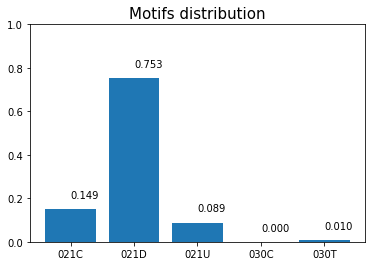

In [13]:
f.plot_motif_distr(counter)

Motif enrichment

In [13]:
from tqdm import tqdm
from matplotlib import pyplot as plt

In [14]:
noise_list = np.linspace(0, 80000, 11).astype(int)
score_list = []
for noise in tqdm(noise_list):
    shuffled_matrix = f.get_shuffled_matrix(interaction_matrix, noise)
    score_list.append(1-f.corruption_score(interaction_matrix, shuffled_matrix))

100%|██████████| 11/11 [02:08<00:00, 11.67s/it]


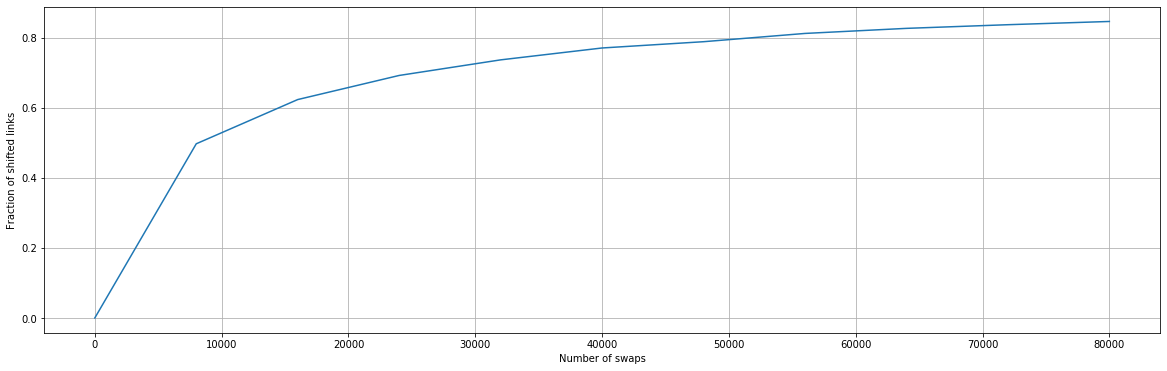

In [15]:
plt.figure(figsize=(20, 6))
plt.grid()
plt.ylabel("Fraction of shifted links")
plt.xlabel("Number of swaps")
plt.plot(noise_list, score_list);

In [16]:
ffl_nodes = list(set(sum([list(map(int, x.split("_"))) for x in motifs_orig], [])))
interaction_matrix_ffl = np.zeros((len(ffl_nodes), len(ffl_nodes)))
for motif in motifs_orig:
    motif = f.split_motif(motif)
    motif_new = list(ffl_nodes.index(x) for x in motif)
    interaction_matrix_ffl[np.ix_(motif_new, motif_new)] = \
    interaction_matrix[np.ix_(motif, motif)]
interaction_matrix_ffl.shape, interaction_matrix_ffl.sum()

((993, 993), 4023.0)

In [17]:
motifs_network = f.build_vmn(motifs_orig, verbose=True)

100%|██████████| 8617476/8617476 [00:39<00:00, 220275.38it/s]


In [19]:
V = nx.Graph(motifs_network)
nx.is_connected(V)

False

In [26]:
# components = list(nx.algorithms.components.connected_components(V))
main_ffl_motifs = [motifs_orig[i] for i in components[0]]

In [28]:
len(main_ffl_motifs), len(main_ffl_motifs)/len(motifs_orig)

(4150, 0.9995183044315993)

In [3]:
interaction_matrix = joblib.load("./networks/human/interaction_matrix.gz")

In [4]:
interaction_matrix.shape, interaction_matrix.sum()

((2862, 2862), 8427.0)

In [9]:
%%time
motifs, counter = f.motif_search(cfg, interaction_matrix, batch_size=10000)
motifs_orig = motifs["030T"]
counter

CPU times: user 907 ms, sys: 102 ms, total: 1.01 s
Wall time: 4.1 s


{'021C': 64810, '021D': 328320, '021U': 38680, '030C': 85, '030T': 4152}

In [5]:
N_SIMS = 1000
N_STEPS = 10
N_SWAPS = 60000
counters = f.generate_random_networks(cfg, interaction_matrix, N_SIMS, N_STEPS, N_SWAPS)

100%|██████████| 100/100 [07:02<00:00,  4.22s/it]


In [6]:
joblib.dump(counters, "./networks/human/shuffled_counters.gz");

In [7]:
counters = joblib.load("./networks/human/shuffled_counters.gz");

100%|██████████| 1000/1000 [00:04<00:00, 237.47it/s]


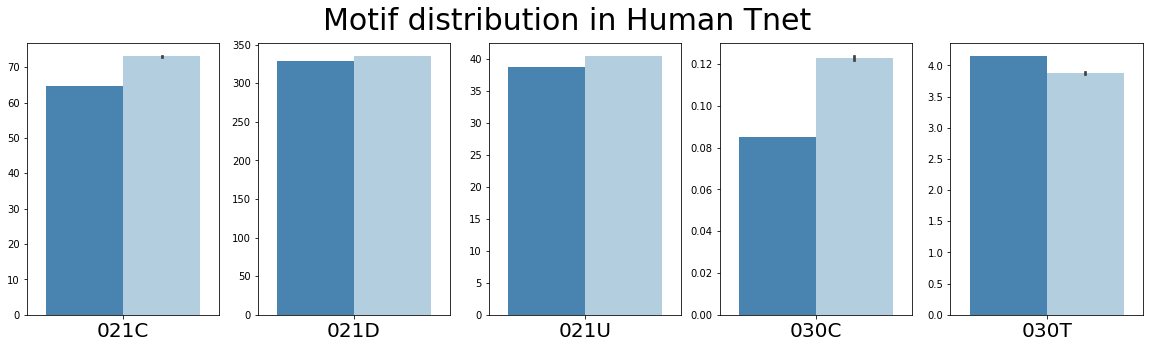

In [10]:
f.plot_distr(counters, counter, label="Motif distribution in Human Tnet", highlight=False);

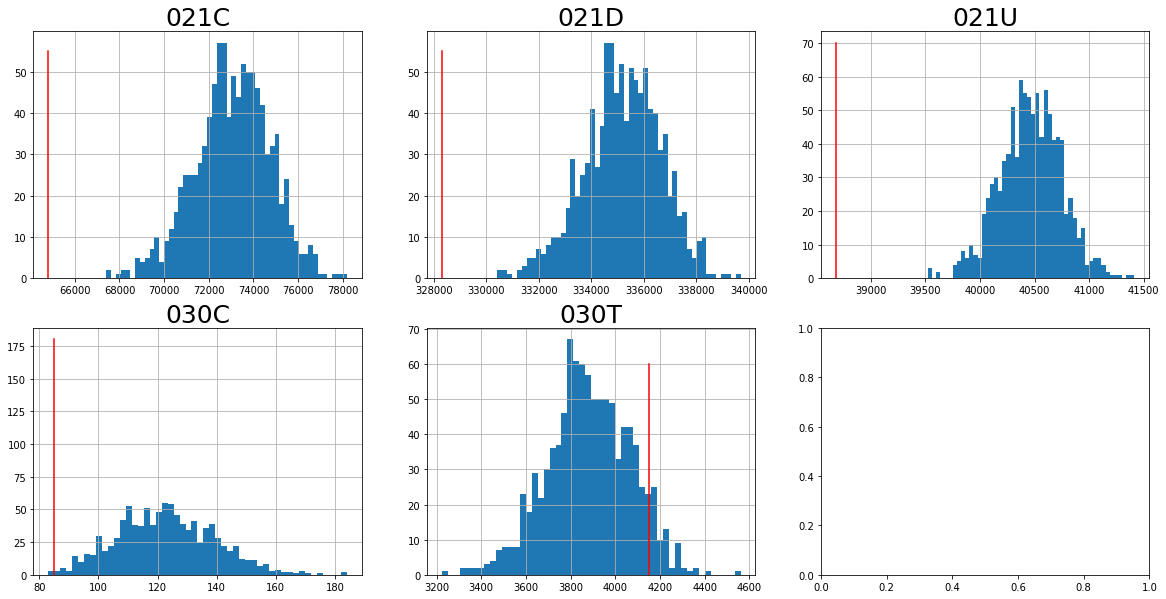

In [11]:
f.plot_distr_2(counters, counter, ticks = [55, 55, 70, 180, 60])

In [12]:
f.build_zscores_report(counters, counter)

,N_real,mean(N_rand),sd(N_rand),Z-score,P-value,Result
021C,64810,73060.5,1684.39,-4.89824,0,< 0.01
021D,328320,335191,1468.23,-4.67994,0,< 0.01
021U,38680,40463.2,281.554,-6.33358,0,< 0.01
030C,85,122.97,16.2777,-2.33263,0.003,< 0.05
030T,4152,3880.66,186.654,1.45373,0.072,non-significant


In [27]:
f.build_zscores_report(counters, counter)

,N_real,mean(N_rand),sd(N_rand),Z-score,P-value,Result
021C,40969,45851.5,862.984,-5.65775,0,< 0.01
021D,135077,138709,698.981,-5.19599,0,< 0.01
021U,20789,22527.9,184.583,-9.42046,0,< 0.01
030C,60,81.372,11.6947,-1.8275,0.033,non-significant
030T,1956,1540.48,84.4663,4.91938,0,< 0.01


# Regnetwork

In [18]:
HUMAN_NETWORK_PATH = "./networks/human/regnet/"

In [19]:
edges = pd.read_csv(os.path.join(HUMAN_NETWORK_PATH, "human.source"), sep="\t", header=None)
edges.sample(10)

,0,1,2,3
320983,hsa-miR-542-3p,MIMAT0003389,CLYBL,171425
60671,MYC,4609,MRPS2,51116
343798,hsa-miR-612,MIMAT0003280,JAG1,182
243194,hsa-miR-24,MIMAT0000080,HEG1,57493
192969,hsa-miR-132,MIMAT0000426,PITRM1,10531
361544,hsa-miR-885-3p,MIMAT0004948,LZTS2,84445
156778,SP1,6667,hsa-miR-3665,MIMAT0018087
8520,XBP1,7494,CD2BP2,10421
347744,hsa-miR-630,MIMAT0003299,MAP3K2,10746
283847,hsa-miR-409-3p,MIMAT0001639,CSTA,1475


In [20]:
edges = pd.read_csv(
    os.path.join(HUMAN_NETWORK_PATH, "human.source"), sep="\t", header=None
)[[0, 2]]
edges.columns = ["Tf", "Tg"]
nodes = sorted(np.unique(np.concatenate((edges.Tf.unique(), edges.Tg.unique()))))
nodes = pd.DataFrame(data=range(len(nodes)), index=nodes, columns=["idx"])
print(f"Total genes number:\t{len(nodes)}")
print(f"Interactions number:\t{len(edges)}")
edges.head()

Total genes number:	23336
Interactions number:	372774


,Tf,Tg
0,USF1,S100A6
1,USF1,DUSP1
2,USF1,C4A
3,USF1,ABCA1
4,TP53,TP73


In [21]:
edges_ = edges.join(nodes, on="Tf").join(nodes, on="Tg", lsuffix="_tf", rsuffix="_tg")
tf_nodes = edges_["idx_tf"].unique()
print(f"Total TF:\t{len(tf_nodes)}")
tg_nodes = edges_["idx_tg"].unique()
print(f"Total TG:\t{len(tg_nodes)}")
tf_x_tg_nodes = np.array(sorted(set(tf_nodes) & set(tg_nodes)))
print(f"TF and TG:\t{len(tf_x_tg_nodes)}")
tg_only_nodes = np.array(sorted(set(tg_nodes) - set(tf_nodes)))
print(f"TG only:\t{len(tg_only_nodes)}")
tf_only_nodes = np.array(sorted(set(tf_nodes) - set(tg_nodes)))
print(f"TF only:\t{len(tf_only_nodes)}")

meta = tf_nodes, tf_only_nodes, tg_nodes, tg_only_nodes, tf_x_tg_nodes
joblib.dump(meta, os.path.join(HUMAN_NETWORK_PATH, "meta.pkl"));

Total TF:	2078
Total TG:	23158
TF and TG:	1900
TG only:	21258
TF only:	178


In [22]:
def build_Tnet(edges, n):
    Tnet = np.zeros((n, n))
    Tnet[edges[:, 0], edges[:, 1]] = 1
    return Tnet

np_edges = edges_[["idx_tg", "idx_tf"]].values
interaction_matrix = build_Tnet(np_edges, len(nodes))

if not os.path.exists(HUMAN_NETWORK_PATH):
    os.mkdir(HUMAN_NETWORK_PATH)

joblib.dump(interaction_matrix, os.path.join(HUMAN_NETWORK_PATH, "interaction_matrix.gz"));

In [23]:
print(f"Total nodes: {interaction_matrix.shape[0]}")
print(f"Total edges: {interaction_matrix.sum():.0f}")

Total nodes: 23336
Total edges: 371517


In [57]:
%%time
motifs, counter = f.motif_search(cfg, interaction_matrix, batch_size=10000, verbose=True)
motifs_orig = motifs["030T"]
counter

14482it [27:22,  8.82it/s]


CPU times: user 8min 14s, sys: 6min 44s, total: 14min 59s
Wall time: 38min 11s


{'021C': 6561521,
 '021D': 125097781,
 '021U': 4529991,
 '030C': 2834,
 '030T': 351063}

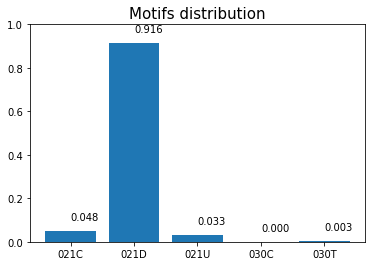

In [58]:
f.plot_motif_distr(counter)